In [1]:
import paddle
from paddle.nn import Transformer
from paddle.io import Dataset
import os
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

In [2]:
code_path='camel_code.txt'
comment_path='comment.txt'

In [3]:
def creat_dataset(a,b):
    # a : code
    # b: comment
    with open(a,encoding='utf-8') as tc:
        lines1=tc.readlines()
        for i in range(len(lines1)):
             lines1[i]="<start> "+lines1[i].strip('\n')+" <end>"
    with open(b,encoding='utf-8') as ts:
        lines2=ts.readlines()
        for i in range(len(lines2)):
            lines2[i]="<start> "+lines2[i].strip('\n')+" <end>"
    if(len(lines1)!=len(lines2) ):
        print("Data volume does not match")
    return lines1,lines2

code,comment=creat_dataset(code_path,comment_path)

In [4]:
print(code[0])
print(comment[0])

<start> public synchronized void info ( string msg ) { log record record = new log record ( level . info , msg ) ; log ( record ) ; } <end>
<start> logs a info message <end>


In [5]:
def build_cropus(data):
    crpous=[]
    for i in range(len(data)):
        cr=data[i].strip().lower()
        cr=cr.split()
        crpous.extend(cr)
    return crpous

In [6]:
# 构造词典，统计每个词的频率，并根据频率将每个词转换为一个整数id
def build_dict(corpus,frequency):
    # 首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1

    # 将这个词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    # 一般来说，出现频率高的高频词往往是：I，the，you这种代词，而出现频率低的词，往往是一些名词，如：nlp
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)
    
    # 构造3个不同的词典，分别存储，
    # 每个词到id的映射关系：word2id_dict
    
    # 每个id到词的映射关系：id2word_dict
    word2id_dict = {'<pad>':0,'<unk>':1}
   
    id2word_dict = {0:'<pad>',1:'<unk>'}

    # 按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    for word, freq in word_freq_dict:
        if freq>frequency:
            curr_id = len(word2id_dict)
            word2id_dict[word] = curr_id
            id2word_dict[curr_id] = word
        else:
            word2id_dict[word]=1
    return word2id_dict, id2word_dict


In [7]:
word_fre=2
code_word2id_dict,code_id2word_dict=build_dict(build_cropus(code),word_fre)
comment_word2id_dict,comment_id2word_dict=build_dict(build_cropus(comment),word_fre)

In [8]:
code_maxlen=200
comment_maxlen=30
code_vocab_size=len(code_id2word_dict)
comment_vocab_size=len(comment_id2word_dict)
print(code_vocab_size)
print(comment_vocab_size)

31921
22256


In [9]:
def build_tensor(data,dicta,maxlen):
    tensor=[]
    for i in range(len(data)):
        subtensor=[]
        lista=data[i].split()
        for j in range(len(lista)):
            index=dicta.get(lista[j])
            subtensor.append(index)
    
        if len(subtensor) < maxlen:
            subtensor+=[0]*(maxlen-len(subtensor))
        else:
            subtensor=subtensor[:maxlen]

        tensor.append(subtensor)
    return tensor

code_tensor=build_tensor(code,code_word2id_dict,code_maxlen)
comment_tensor=build_tensor(comment,comment_word2id_dict,comment_maxlen)
code_tensor=np.array(code_tensor)
comment_tensor=np.array(comment_tensor)

In [10]:
test_code_tensor=code_tensor[:20000]
val_code_tensor=code_tensor[20000:40000]
train_code_tensor=code_tensor[40000:]

test_comment_tensor=comment_tensor[:20000]
val_comment_tensor=comment_tensor[20000:40000]
train_comment_tensor=comment_tensor[40000:]

print(test_code_tensor.shape[0])
print(val_code_tensor.shape)
print(train_code_tensor.shape)

20000
(20000, 200)
(445812, 200)


In [11]:
class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, code,comment):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.code = code
        self.comment=comment

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        return self.code[index], self.comment[index]

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.code.shape[0]

BATCH_SIZE=128

train_batch_num=train_code_tensor.shape[0]//BATCH_SIZE #3482
val_batch_num=val_code_tensor.shape[0]//BATCH_SIZE #156
print(train_batch_num)
print(val_batch_num)

3482
156


In [12]:
# 测试定义的数据集
train_dataset = MyDataset(train_code_tensor,train_comment_tensor)
train_loader = paddle.io.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
val_dataset=MyDataset(val_code_tensor,val_comment_tensor)
val_loader=paddle.io.DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
    

In [13]:
def get_angles(pos,i,d_model):
    angle_rate=1/np.power(10000,(2*(i//2))/np.float32(d_model))
    return pos*angle_rate

def get_position_embedding(sentence_length,d_model):
    angle_rads=get_angles(np.arange(sentence_length)[:,np.newaxis],
                         np.arange(d_model)[np.newaxis,:],
                         d_model)
    sines=np.sin(angle_rads[:,0::2])
    cosines=np.cos(angle_rads[:,1::2])
    
    position_embedding=np.concatenate([sines,cosines],axis=-1)
    position_embedding=paddle.to_tensor(position_embedding[np.newaxis,...])
    
    return paddle.cast(position_embedding,dtype='float32')

In [14]:
def create_padding_mask(seq):
    zeo=paddle.zeros(seq.shape,seq.dtype)
    padding_mask=paddle.cast(paddle.equal(seq,zeo),dtype='float32')
    return paddle.unsqueeze(padding_mask,axis=[1,2])

def create_look_ahead_mask(length):
    return paddle.tensor.triu((paddle.ones((length, length))),1)

def creat_mask(inp,tar):
    encoder_padding_mask=create_padding_mask(inp)
    encoder_decoder_padding_mask=create_padding_mask(inp)
    
    look_ahead_mask=create_look_ahead_mask(tar.shape[1])
    decoder_padding_mask=create_padding_mask(tar)
    deocder_mask=paddle.maximum(decoder_padding_mask,look_ahead_mask)
    
    return encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask

In [15]:
def scaled_dot_product_attention(q, k, v, mask):
 
    # 相乘前转置y
    matmul_qk = paddle.matmul(q, k, transpose_y=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = paddle.cast(paddle.shape(k)[-1], dtype='float32')
    scaled_attention_logits = matmul_qk / paddle.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = paddle.nn.functional.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = paddle.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output

In [16]:
class MultiHeadAttention(paddle.nn.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = paddle.nn.Linear(d_model,d_model)
        self.wk = paddle.nn.Linear(d_model,d_model)
        self.wv = paddle.nn.Linear(d_model,d_model)

        self.dense = paddle.nn.Linear(d_model,d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = paddle.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return paddle.transpose(x, perm=[0, 2, 1, 3])

    def forward(self, v, k, q, mask):
        
        batch_size = q.shape[0]
       
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = paddle.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = paddle.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
                                    
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
#y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
y= paddle.uniform((1,60,512))
out= temp_mha(y, k=y, q=y, mask=None)
out.shape

[1, 60, 512]

In [17]:
def point_wise_feed_forward_network(d_model, dff):
    return paddle.nn.Sequential(
        paddle.nn.Linear(d_model,dff),  # (batch_size, seq_len, dff)
        paddle.nn.ReLU(),
        paddle.nn.Linear(dff,d_model)  # (batch_size, seq_len, d_model)
    )


In [18]:
class EncoderLayer(paddle.nn.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # 如果是单个整数，则此模块将在最后一个维度上规范化（此时最后一维的维度需与该参数相同）
        self.layernorm1 = paddle.nn.LayerNorm(d_model,epsilon=1e-6)
        self.layernorm2 = paddle.nn.LayerNorm(d_model,epsilon=1e-6)

        self.dropout1 = paddle.nn.Dropout(p=rate)
        self.dropout2 = paddle.nn.Dropout(p=rate)

    def forward(self, x, mask):

        attn_output= self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


In [19]:
class DecoderLayer(paddle.nn.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = paddle.nn.LayerNorm(d_model,epsilon=1e-6)
        self.layernorm2 = paddle.nn.LayerNorm(d_model,epsilon=1e-6)
        self.layernorm3 = paddle.nn.LayerNorm(d_model,epsilon=1e-6)

        self.dropout1 = paddle.nn.Dropout(p=rate)
        self.dropout2 = paddle.nn.Dropout(p=rate)
        self.dropout3 = paddle.nn.Dropout(p=rate)


    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
            
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1= self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2= self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
            
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3


In [20]:
class Encoder(paddle.nn.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,maximum_position_encoding, rate=0.1):
                
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = paddle.nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = get_position_embedding(maximum_position_encoding,self.d_model) 
                                                
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
                        

        self.dropout =paddle.nn.Dropout(p=rate)

    def forward(self, x,  mask):

        seq_len = x.shape[1]
        

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
     
        x *= np.sqrt(self.d_model).astype(np.float32)
        
       
        x +=self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)


In [21]:
class Decoder(paddle.nn.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = paddle.nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = get_position_embedding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
                        
        self.dropout = paddle.nn.Dropout(p=rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
            
        seq_len = x.shape[1]
       
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= np.sqrt(self.d_model).astype(np.float32)
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x= self.dec_layers[i](x, enc_output,look_ahead_mask, padding_mask)
                                                
        # x.shape == (batch_size, target_seq_len, d_model)
        return x
class Trans(paddle.nn.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,target_vocab_size, pe_input, pe_target, rate=0.1): 
                
        super(Trans, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
                            
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
                            
        self.final_layer = paddle.nn.Linear(d_model,target_vocab_size)

    
    def forward(self, inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask):
            
        enc_output = self.encoder(inp,  enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output


In [22]:
num_layers = 4
d_model = 256
dff = 512
num_heads = 8

dropout_rate = 0.2

trans = Trans(num_layers,d_model,num_heads,dff, 
code_vocab_size,comment_vocab_size,pe_input=code_vocab_size, pe_target=comment_vocab_size) 

for batch_id, data in enumerate(train_loader()):
    x_data = data[0]
    y_data = data[1]
    y_inp=y_data[:,:-1]
    y_real=y_data[:,1:]#[batch_size,seq_len]
    encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask=creat_mask(x_data,y_inp)
    print(encoder_padding_mask.shape)
    print(deocder_mask.shape)
    print(encoder_decoder_padding_mask.shape)
    break

[128, 1, 1, 200]
[128, 1, 29, 29]
[128, 1, 1, 200]


In [34]:
paddle.summary(trans,[(128,200),(128,29),(128, 1, 1, 200),(128, 1, 29, 29),(128, 1, 1, 200)],dtypes='int64')
for batch_id, data in enumerate(train_loader()):
     if batch_id%100==0:
                print('batch=',batch_id)

-----------------------------------------------------------------------------------------------------------------------
 Layer (type)                             Input Shape                                Output Shape         Param #    
  Embedding-1                             [[128, 200]]                             [128, 200, 256]       8,171,776   
   Dropout-9                           [[128, 200, 256]]                           [128, 200, 256]           0       
   Encoder-1                     [[128, 200], [128, 1, 1, 200]]                    [128, 200, 256]           0       
  Embedding-2                             [[128, 29]]                               [128, 29, 256]       5,697,536   
  Dropout-22                            [[128, 29, 256]]                            [128, 29, 256]           0       
   Decoder-1    [[128, 29], [128, 200, 256], [128, 1, 29, 29], [128, 1, 1, 200]]    [128, 29, 256]           0       
   Linear-69                            [[128, 29, 256

In [37]:
epochs=2

def draw_loss(a,b):
    x_list=[]
    for i in range(len(a)):
        x_list.append(i)
    plt.title("LOSS")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x_list,a,marker='s',label="train")
    plt.plot(x_list,b,marker='s',label="val")
    plt.legend()
    plt.savefig('LOSS.png')
    plt.show()

def train():
    #clip = paddle.nn.ClipGradByGlobalNorm(clip_norm=5.0)
    scheduler = paddle.optimizer.lr.NoamDecay(d_model, warmup_steps=4000)# ,verbose=True
    # opt=paddle.optimizer.Adam(learning_rate=scheduler,beta1=0.9, beta2=0.98, epsilon=1e-09,parameters=trans.parameters(),grad_clip=clip)
    
    opt=paddle.optimizer.Adam(learning_rate=scheduler,beta1=0.9, beta2=0.98, epsilon=1e-09,parameters=trans.parameters())

    ce_loss = paddle.nn.CrossEntropyLoss(reduction='none')
    train_loss=[]
    val_loss=[]
    for epoch in range(epochs):
        print("epoch:{}".format(epoch))
        train_epoch_loss=0

        # 此处声明模型训练，使用drpout
        trans.train()

        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            y_inp=y_data[:,:-1]
            y_real=y_data[:,1:]#[batch_size,seq_len]
            
            
             encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask=creat_mask(x_data,y_inp)
            
            pre=trans(x_data,y_inp,encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask)
            #[batch_size,seq_len,vocab_size]
            #print(y_real.dtype)
            y_real = y_real.astype('int64')
            batch_loss=ce_loss(pre,y_real)
            # 消除padding的0的影响
            zeo=paddle.zeros(y_real.shape,y_real.dtype)
            mask=paddle.cast(paddle.logical_not(paddle.equal(y_real,zeo)),dtype=pre.dtype)
            batch_loss*=mask
            batch_loss=paddle.mean(batch_loss)

            train_epoch_loss+=batch_loss.numpy()

            batch_loss.backward()

            
            #print('batch=',batch_id,' batch_loss= ',batch_loss.numpy())
            # 更新参数
            opt.step()

            # 梯度清零
            opt.clear_grad()
            #学习率更新
            scheduler.step()
            #break
        ava_loss=train_epoch_loss/train_batch_num
        train_loss.append(ava_loss)
        

        print("train epoch: {}  AVALOSS: {}\n".format(epoch,ava_loss))
        #break

        val_epoch_loss=0
        # 声明模型在预测，不使用dropout
        trans.eval()
        for batch_id, data in enumerate(val_loader()):
            x_data = data[0]
            y_data = data[1]
            y_inp=y_data[:,:-1]
            y_real=y_data[:,1:]
           
            encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask=creat_mask(x_data,y_inp)

            pre=trans(x_data,y_inp,encoder_padding_mask,deocder_mask,encoder_decoder_padding_mask)
            y_real = y_real.astype('int64')
            batch_loss=ce_loss(pre,y_real)
            # 消除padding 的0的影响
            zeo=paddle.zeros(y_real.shape,y_real.dtype)
            mask=paddle.cast(paddle.logical_not(paddle.equal(y_real,zeo)),dtype=pre.dtype)
            batch_loss*=mask
            batch_loss=paddle.mean(batch_loss)

            val_epoch_loss+=batch_loss.numpy()

            
            #print('batch=',batch_id,' batch_loss= ',batch_loss.numpy())
        ava_loss=val_epoch_loss/val_batch_num
        
        val_loss.append(ava_loss)
        print("val epoch: {}  AVALOSS: {}\n".format(epoch,ava_loss))
        
    # 至此，训练结束。下面绘制loss图
    draw_loss(train_loss,val_loss)

   
    


epoch:0


C:\Users\Gao taiyu\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dygraph\math_op_patch.py:73: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = core.ops.fill_constant(out, 'dtype', dtype, 'shape', shape,


batch= 0  batch_loss=  [3.8124182]
batch= 100  batch_loss=  [4.158208]
batch= 200  batch_loss=  [3.7337093]
batch= 300  batch_loss=  [3.8947823]
batch= 400  batch_loss=  [3.727067]
batch= 500  batch_loss=  [3.731418]
batch= 600  batch_loss=  [4.1078815]
batch= 700  batch_loss=  [3.7346907]
batch= 800  batch_loss=  [3.9407213]
batch= 900  batch_loss=  [3.8382058]
batch= 1000  batch_loss=  [3.9398248]
batch= 1100  batch_loss=  [4.123186]
batch= 1200  batch_loss=  [3.8168561]
batch= 1300  batch_loss=  [3.8385425]
batch= 1400  batch_loss=  [3.8334982]
batch= 1500  batch_loss=  [3.9503074]
batch= 1600  batch_loss=  [3.6005743]
batch= 1700  batch_loss=  [4.149143]
batch= 1800  batch_loss=  [3.97402]
batch= 1900  batch_loss=  [3.7685347]
batch= 2000  batch_loss=  [3.9916303]
batch= 2100  batch_loss=  [3.921741]
batch= 2200  batch_loss=  [3.849634]
batch= 2300  batch_loss=  [3.9011202]
batch= 2400  batch_loss=  [3.8328252]
batch= 2500  batch_loss=  [4.2174406]
batch= 2600  batch_loss=  [3.8797

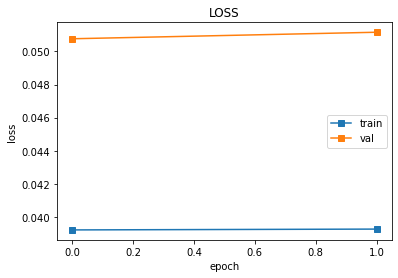

In [38]:
train()


In [39]:

paddle.save(trans.state_dict(), "trans_net.pdparams")
#paddle.save(opt.state_dict(), "opt.pdopt")


In [41]:
 def evalute(code):
        result=''
        # code.shape(1,500)
        code=paddle.unsqueeze(code,axis=0)
        
        # decoder_input.shape(1,1)
        decoder_input=paddle.unsqueeze(paddle.to_tensor([comment_word2id_dict['<start>']]),axis=0)
        
        for i in range(comment_maxlen):
            encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask=creat_mask(code,decoder_input)
            #(batch_size,output_target_len,target_vocab_size)
            pre=trans(code,decoder_input,encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask)
            
            pre=pre[:,-1:,:]
            
            pre_id=paddle.argmax(pre,axis=-1)
           # print(pre_id)
            predicted_id = paddle.cast(pre_id, dtype='int64')
          #  print(predicted_id)
            pre_id=pre_id.numpy()[0][0]
           # print(pre_id)
            if comment_id2word_dict[pre_id]=='<end>':
                return result
            
            result+=comment_id2word_dict[pre_id]+' '
            decoder_input = decoder_input.astype('int64')
            decoder_input=paddle.concat(x=[decoder_input,predicted_id],axis=-1)
           
        return result

def translate():
    with open('result.txt','w+') as re:
        for i in tqdm(range(len(test_code_tensor))):
        #for i in range(100):    
            result=evalute(paddle.to_tensor(test_code_tensor[i]))
            re.write(result+'\n')
            #print(result)
translate()


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [11:11:41<00:00,  2.02s/it]


In [43]:
with open('result.txt','r') as re:
    pre=re.readlines()

with open(code_path,'r') as scode:
    code=scode.readlines()

with open(comment_path,'r') as scomment:
    comment=scomment.readlines()

for i in range(5):
    print('code: ',code[i].strip())
    print('真实注释：',comment[i].strip())

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 1943: character maps to <undefined>

In [45]:
with open('result.txt','r') as re:
    pre=re.readlines()

#with open(code_path,'r') as scode:
#    code=scode.readlines()

with open(comment_path,'r') as scomment:
    comment=scomment.readlines()

for i in range(5):
    print('code: ',code[i].strip())
    print('真实注释：',comment[i].strip())
    print('预测注释：',pre[i])


code:  <start> public synchronized void info ( string msg ) { log record record = new log record ( level . info , msg ) ; log ( record ) ; } <end>
真实注释： logs a info message
预测注释： viewpoint doc filter l possible doc doc world initialized filter wss doc doc doc que twitterlisttimeline ha deselect booleanliteral doc doc filter doc backwards viewpoint ha smartphone hubs doc doc 

code:  <start> public void handle gateway receiver create ( gateway receiver recv ) throws management exception { if ( ! is service initialised ( str_ ) ) { return ; } if ( ! recv . is manual start ( ) ) { return ; } create gateway receiver m bean ( recv ) ; } <end>
真实注释： handles gateway receiver creation
预测注释： initialized initialized under ormlite doc highlight httpexception highlight highlight highlight enforce que deselect ha ormlite ormlite injecting deselect starting injecting bytebuffer highlight doc under doc ormlite document deselect doc username 

code:  <start> public void data changed ( i data provider 